In [1]:
from IPython.display import clear_output
from google.colab import files
files.upload()
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d crawford/cat-dataset
!unzip cat-dataset.zip
!rm cat-dataset.zip
clear_output()

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torch import optim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from glob import glob

In [3]:
torch.random.manual_seed(123)
np.random.seed(123)

BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCHS = 100
PATH = r'/content/drive/My Drive/data/pussy_model.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ColorJitter(brightness=(0.95, 1.05),
                                            contrast=(0.95, 1.05),
                                            saturation=(0.95, 1.05),
                                            hue=0.05),
                              T.RandomHorizontalFlip(p=0.1),
                              T.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2)),
                              T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
                              T.RandomRotation(degrees=(-3, 3)),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], 
                                          std=[0.229, 0.224, 0.225]),
])

valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], 
                                          std=[0.229, 0.224, 0.225])
])

invTrans = T.Compose([T.Normalize(mean = [ 0., 0., 0. ],
                                  std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                      T.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                  std = [ 1., 1., 1. ]),
                      T.ToPILImage(),
                      ])

In [5]:
def open_annots(path):
    with open(path, 'r') as annot_file:
        annots = annot_file.read().split()[1:]
    return annots

In [6]:
images_dir = glob('cats/*/*' + '.jpg')
annots_dir = glob('cats/*/*' + '.cat')

images_dir = sorted([str(dir) for dir in images_dir])
annots_dir = sorted([str(ann) for ann in annots_dir])

data = pd.DataFrame(data={'img_dir': images_dir, 'landmarks': annots_dir})
data['landmarks'] = data['landmarks'].apply(lambda x: np.asarray(open_annots(x), dtype=np.float32))
data.sample(5)

,img_dir,landmarks
9834,cats/CAT_06/00001477_015.jpg,"[226.0, 168.0, 277.0, 167.0, 254.0, 203.0, 184..."
2058,cats/CAT_01/00000142_017.jpg,"[193.0, 174.0, 286.0, 180.0, 237.0, 245.0, 120..."
7159,cats/CAT_04/00001081_006.jpg,"[378.0, 118.0, 377.0, 187.0, 323.0, 177.0, 411..."
2335,cats/CAT_01/00000174_028.jpg,"[208.0, 192.0, 288.0, 216.0, 240.0, 265.0, 151..."
9587,cats/CAT_06/00001442_004.jpg,"[172.0, 171.0, 210.0, 148.0, 210.0, 199.0, 146..."


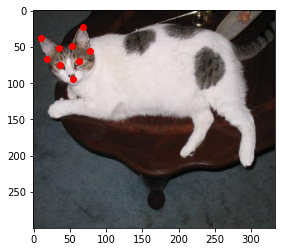

In [7]:
idx = np.random.randint(len(data))
img = cv2.imread(data.iloc[idx, 0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

annots = data.iloc[idx, 1]
x = annots[0::2]
y = annots[1::2]

plt.imshow(img)
plt.scatter(x, y, marker='o', c='red')
plt.show()

In [7]:
train, test = train_test_split(data, test_size=0.01, shuffle=True, random_state=123)
train, valid = train_test_split(train, test_size=0.1, shuffle=True, random_state=123)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.shape, valid.shape, test.shape

((8907, 2), (990, 2), (100, 2))

In [8]:
class CatDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        row = self.df.iloc[ix].squeeze()
        image = cv2.imread(row['img_dir'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h,w = image.shape[:2]
        x = (row['landmarks'][0::2] / 255. / w * IMAGE_SIZE).tolist()
        y = (row['landmarks'][1::2] / 255. / h * IMAGE_SIZE).tolist()
        return image, x+y

    def collate_fn(self, batch):
        images, keypoints = list(zip(*batch))
        images = [self.transforms(img)[None]/255. for img in images]
        keypoints = [torch.tensor([kp]) for kp in keypoints]
        images, keypoints = [torch.cat(i).to(device) for i in [images, keypoints]]
        return images, keypoints

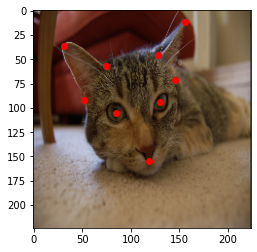

In [ ]:
ds = CatDataset(train, train_transforms)
im, kp = ds[5]
kp = np.array(kp)*255
x = kp[:9]
y = kp[9:]
im = cv2.resize(im , (IMAGE_SIZE, IMAGE_SIZE))

plt.imshow(im)
plt.scatter(x, y, marker='o', c='red')
plt.show()

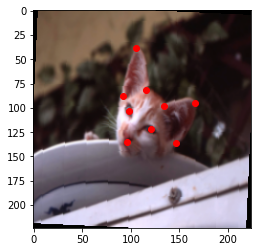

In [ ]:
dl = DataLoader(ds, batch_size=1, collate_fn=ds.collate_fn)
d = next(iter(dl))
ims, kps = d
ims = ims.squeeze().cpu().detach()*255
ims = invTrans(ims)
plt.imshow(ims)
kps = kps.squeeze().cpu().detach().numpy()*255
x = kps[:9]
y = kps[9:]
plt.scatter(x,y, c='red', marker='o')
plt.show()

In [9]:
train_dataset = CatDataset(train, valid_transforms)  # train_transforms
valid_dataset = CatDataset(valid, valid_transforms)
test_dataset = CatDataset(test, valid_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=test_dataset.collate_fn)

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, path=PATH):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss, epoch=None, model=None, optimizer=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = { 
                          'epoch': epoch,
                          'model': model,
                          'optimizer': optimizer,
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def load_model(path, device=device):
    if device == 'cuda':
        checkpoint = torch.load(path)
    else:
        checkpoint = torch.load(path, map_location=torch.device('cpu'))
    epoch = checkpoint['epoch']
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    return epoch, model, optimizer

In [11]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=18):
        super().__init__()

        self.encoder = models.vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        x = nn.Sigmoid()(x)
    
        return x

In [12]:
def get_model():
    model = models.efficientnet_b0(pretrained=True, progress=False)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Linear(1280, 625),
        #nn.BatchNorm1d(625),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(625, 256),
        #nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(256, 18),
        nn.Sigmoid()
    )
    return model.to(device)

def get_vgg_model():
    model = models.vgg16(pretrained=True, progress=False)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.AdaptiveAvgPool2d(2),
        nn.Flatten()
    )
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 18),
        nn.Sigmoid()
    )
    return model.to(device)

In [13]:
from torchsummary import summary

model = get_model()
umodel = UNet().to(device)
summary(umodel, (3,224,224))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
       BatchNorm2d-3         [-1, 64, 224, 224]             128
       BatchNorm2d-4         [-1, 64, 224, 224]             128
              ReLU-5         [-1, 64, 224, 224]               0
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,928
            Conv2d-8         [-1, 64, 224, 224]          36,928
       BatchNorm2d-9         [-1, 64, 224, 224]             128
      BatchNorm2d-10         [-1, 64, 224, 224]             128
             ReLU-11         [-1, 64, 224, 224]               0
             ReLU-12         [-1, 64, 224, 224]               0
        MaxPool2d-13         [-1, 64, 112, 112]               0
        MaxPool2d-14         [-1, 64, 1

In [14]:
class MSELoss(nn.Module):
    def forward(self, y, x):
        return torch.mean((y-x)**2)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-7, factor=0.1)
early = EarlyStopping()
metric = lambda x, y: torch.mean((y-x)**2)

In [15]:
def train_one_batch(model, data, criterion, optimizer):
    model.train()
    images, kps = data
    optimizer.zero_grad()
    _kps = model(images)
    loss = criterion(_kps, kps)
    loss.backward()
    optimizer.step()
    mse = metric(kps, _kps)
    return loss.item(), mse.item()

@torch.no_grad()
def validate(model, data, criterion):
    model.eval()
    images, kps = data
    _kps = model(images)
    loss = criterion(_kps, kps)
    mse = metric(kps, _kps)
    return loss.item(), mse.item()

@torch.no_grad()
def show_prediction(model, image, kps):
    model.eval()
    _kps = model(image[None])
    ims = image.squeeze().cpu().detach()*255
    ims = invTrans(ims)
    plt.imshow(ims)
    kps = kps.squeeze().cpu().detach().numpy()*255
    x = kps[:9]
    y = kps[9:]
    plt.scatter(x,y, c='green', marker='o')
    _kps = _kps.squeeze().cpu().detach().numpy()*255
    x_ = _kps[:9]
    y_ = _kps[9:]
    plt.scatter(x_,y_, c='red', marker='o')
    plt.show()
    plt.pause(0.001)

In [16]:
ep, model, optimizer = load_model(PATH)

Epoch 10/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0856, train mse: 0.0128


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0827, valid mse: 0.0121
--------------------------------------------------


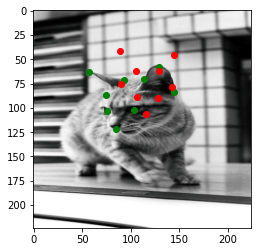

Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 11/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0843, train mse: 0.0125


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0822, valid mse: 0.0121
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 12/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0834, train mse: 0.0123


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0819, valid mse: 0.0120
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 13/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0825, train mse: 0.0121


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0824, valid mse: 0.0122
--------------------------------------------------
INFO: Early stopping counter 1 of 10
Epoch 14/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0816, train mse: 0.0119


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0820, valid mse: 0.0119
--------------------------------------------------
INFO: Early stopping counter 2 of 10
Epoch 15/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0810, train mse: 0.0118


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0818, valid mse: 0.0120
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 16/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0804, train mse: 0.0116


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0818, valid mse: 0.0120
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 17/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0794, train mse: 0.0114


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0817, valid mse: 0.0120
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 18/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0788, train mse: 0.0113


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0819, valid mse: 0.0119
--------------------------------------------------
INFO: Early stopping counter 1 of 10
Epoch 19/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0779, train mse: 0.0111


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0822, valid mse: 0.0120
--------------------------------------------------
INFO: Early stopping counter 2 of 10
Epoch 20/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0770, train mse: 0.0109


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0823, valid mse: 0.0121
--------------------------------------------------


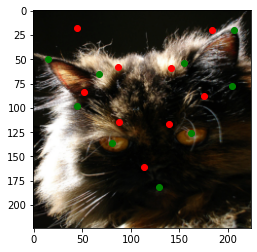

INFO: Early stopping counter 3 of 10
Epoch 21/100


  0%|          | 0/278 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [47]:
train_losses, valid_losses = [], []
train_mse, valid_mse = [], []

try:
    ep = ep
except NameError:
    ep = 0

for epoch in range(ep, EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    epoch_train_losses, epoch_valid_losses = [], []
    epoch_train_mse, epoch_valid_mse = [], []

    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        loss, mse = train_one_batch(model, batch, criterion, optimizer)
        epoch_train_losses.append(loss)
        epoch_train_mse.append(mse)

    epoch_train_loss = np.array(epoch_train_losses).mean()
    epoch_train_mse = np.array(epoch_train_mse).mean()
    train_losses.append(epoch_train_loss)
    train_mse.append(epoch_train_mse)
    print(f'Train loss: {epoch_train_loss:.4f}, train mse: {epoch_train_mse:.4f}')

    for _, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        loss, mse = validate(model, batch, criterion)
        epoch_valid_losses.append(loss)
        epoch_valid_mse.append(mse)

    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    epoch_valid_mse = np.array(epoch_valid_mse).mean()
    valid_losses.append(epoch_valid_loss)
    valid_mse.append(epoch_valid_mse)
    print(f'Valid loss: {epoch_valid_loss:.4f}, valid mse: {epoch_valid_mse:.4f}')

    print('-'*50)

    if (epoch + 1) % 10 == 0:
        imgs, kps = next(iter(valid_dataloader))
        idx = np.random.randint(BATCH_SIZE)
        img, kp = imgs[idx], kps[idx]
        show_prediction(model, img, kp)

    scheduler.step(epoch_valid_loss)
    early(epoch_valid_loss, epoch, model, optimizer)
    if early.early_stop:
        print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
        ep, model, optimizer = load_model(PATH)
        break

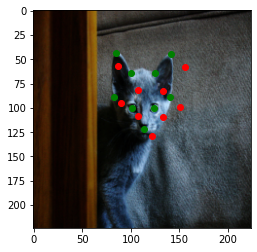

In [48]:
img, kps = next(iter(test_dataloader))
show_prediction(model, img.squeeze(), kps)

In [ ]:
# try U-Net architechture with Sigmoid activation later and with MSE loss (nn.Module)

In [24]:
def train_one_batch(model, data, criterion, optimizer):
    model.train()
    images, kps = data
    optimizer.zero_grad()
    kps_ = model(images)
    #kps_ = kps_[:,:,0,0].clone()
    loss = criterion(kps_, kps)  # MSELoss
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate(model, data, criterion):
    model.eval()
    images, kps = data
    kps_ = model(images)
    #kps_ = kps_[:,:,0,0].clone()
    loss = criterion(kps_, kps)
    return loss.item()

@torch.no_grad()
def show_prediction(model, image, kps):
    model.eval()
    _kps = model(image[None])
    #_kps = _kps[:,:,0,0]
    ims = image.squeeze().cpu().detach()*255
    ims = invTrans(ims)
    plt.imshow(ims)
    kps = kps.squeeze().cpu().detach().numpy()*255
    x = kps[:9]
    y = kps[9:]
    plt.scatter(x,y, c='green', marker='o')
    _kps = _kps.squeeze().cpu().detach().numpy()*255
    x_ = _kps[:9]
    y_ = _kps[9:]
    plt.scatter(x_,y_, c='red', marker='o')
    plt.show()
    plt.pause(0.001)

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-7, factor=0.1)
early = EarlyStopping()

Epoch 2/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0135


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0121
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 3/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0129


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0121
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 4/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0126


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0121
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 5/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0124


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0122
--------------------------------------------------
INFO: Early stopping counter 1 of 10
Epoch 6/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0121


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0122
--------------------------------------------------
INFO: Early stopping counter 2 of 10
Epoch 7/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0119


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0120
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 8/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0117


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0120
--------------------------------------------------
INFO: Early stopping counter 1 of 10
Epoch 9/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0115


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0119
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/pussy_model.pth
Epoch 10/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0112


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0120
--------------------------------------------------


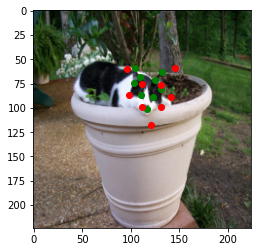

INFO: Early stopping counter 1 of 10
Epoch 11/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0110


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0119
--------------------------------------------------
INFO: Early stopping counter 2 of 10
Epoch 12/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0107


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0120
--------------------------------------------------
INFO: Early stopping counter 3 of 10
Epoch 13/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0105


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0120
--------------------------------------------------
INFO: Early stopping counter 4 of 10
Epoch 14/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0103


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0121
--------------------------------------------------
INFO: Early stopping counter 5 of 10
Epoch 15/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0101


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0122
--------------------------------------------------
INFO: Early stopping counter 6 of 10
Epoch 16/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0098


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0121
--------------------------------------------------
INFO: Early stopping counter 7 of 10
Epoch 17/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0095


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0122
--------------------------------------------------
INFO: Early stopping counter 8 of 10
Epoch 18/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0092


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0123
--------------------------------------------------
INFO: Early stopping counter 9 of 10
Epoch 19/100


  0%|          | 0/278 [00:00<?, ?it/s]

Train loss: 0.0090


  0%|          | 0/30 [00:00<?, ?it/s]

Valid loss: 0.0125
--------------------------------------------------
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Validation loss did not improve for 10 epochs. Training stopped.


FileNotFoundError: ignored

In [51]:
train_losses, valid_losses = [], []
PATH = r'/content/drive/My Drive/data/pussy_umodel.pth'

try:
    ep, model, optimizer = load_model(PATH)
except NameError:
    ep = 0

for epoch in range(ep, EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    epoch_train_losses, epoch_valid_losses = [], []

    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        loss = train_one_batch(model, batch, criterion, optimizer)
        epoch_train_losses.append(loss)

    epoch_train_loss = np.array(epoch_train_losses).mean()
    train_losses.append(epoch_train_loss)
    print(f'Train loss: {epoch_train_loss:.4f}')

    for _, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        loss = validate(model, batch, criterion)
        epoch_valid_losses.append(loss)

    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(epoch_valid_loss)
    print(f'Valid loss: {epoch_valid_loss:.4f}')

    print('-'*50)

    if (epoch + 1) % 10 == 0:
        imgs, kps = next(iter(valid_dataloader))
        idx = np.random.randint(BATCH_SIZE)
        img, kp = imgs[idx], kps[idx]
        show_prediction(model, img, kp)

    scheduler.step(epoch_valid_loss)
    early(epoch_valid_loss, epoch, model, optimizer)
    if early.early_stop:
        print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
        ep, model, optimizer = load_model(PATH)
        break

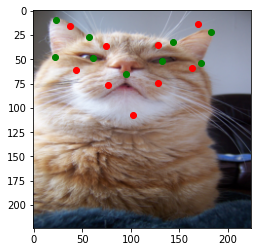

In [59]:
imgs, kps = next(iter(valid_dataloader))
idx = np.random.randint(BATCH_SIZE)
img, kp = imgs[idx], kps[idx]
show_prediction(model, img, kp)

In [ ]:
# limitation: only one cat per image, model suppose there is always a cat on the image
# first detect and crop all cats and sequentially pass them through the landmark model?